# Modell zur Bachelorarbeit

### Einrichtung

In [1]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import math

import pypsa
import pypsa.plot as bmplot

%matplotlib inline

## Setup

Einrichtung aller wichtigen Kompnenten und Einlesen der Daten

Die jeweiligen Daten entstammen einer anderen Bachelorarbeit und werden über die von pandas zur Verfügung gestellten Funktionen aus Excel-Dateien eingelesen und als Dataframe gespeichert. Aus diesem werden dann wiederum nur die benötigten Werte verwendet.

### Variablen

In [2]:
nw = pypsa.Network()

In [3]:
dates = pd.date_range("2015-11-01T04:00:00Z", periods=5, freq="4H")

nw.set_snapshots(dates)

### Einlesen der Datenbanken

In [4]:
cur_path = r"C:\Users\janni\OneDrive\TU Berlin\4 - Abschlussarbeiten\01 - Bachelorarbeit\modell\data\\"

Zuerst werden die zur Verfügung gestellten Daten eingelesen, danach werden diese noch um einige benötigte Werte von Hand erweitert, die zur Durchführung des Unit Commitment nötig sind

In [5]:
gen_data = [pd.DataFrame for i in range(2)]
ex = pd.ExcelFile(cur_path + "Technische Daten Gaskraftwerke.xlsx")

for i in range(len(gen_data)):
    # Extract last two columns from worksheet and only rows 5-13
    gen_data[i] = ex.parse(i).iloc[4:12,[-2,-1]]
    # Use values from first column as index
    gen_data[i].index = gen_data[i].iloc[:,0]
    # Delete column in the middle
    gen_data[i] = gen_data[i].iloc[:, -1]
    gen_data[i].set_value("committable", True)

In [6]:
wind_data = pd.read_excel(cur_path + "Stromlast und Windeinspeisung.xlsx",
                    sheet_name="Tabelle1",
                    header=3,
                    index_col=0,
                    parse_cols="A:F")

# Extract only the first day, every Xh
intervall = 16
wind_data_modell = wind_data.iloc[intervall::intervall,[0,1]].head((96//intervall)-1)

### Temporary Additional code
### ================================================

In [7]:
filenames = ["vertices", "lines", "loads_modell"]
units = ["Bus", "Line", "Load"]
components = [pd.DataFrame for i in range(len(filenames))]

In [8]:
for i in range(len(components)):
    components[i] = pd.read_csv(cur_path + filenames[i] + ".csv")
    components[i].fillna(0,inplace=True)

components[1].rename(columns={"wid":"x","len":"length","cap":"s_nom"},inplace=True)

In [9]:
wind_data_modell["Last"] = wind_data_modell["Last"]/7
gen_data[1][1] = gen_data[1][1]*3
wind_data_modell

,Last,Windeinspeisung Original
"Datum, Zeit",,
2015-11-01T04:00:00Z,5490.714286,6388
2015-11-01T08:00:00Z,6456.142857,5370
2015-11-01T12:00:00Z,6008.714286,4379
2015-11-01T16:00:00Z,7076.857143,5165
2015-11-01T20:00:00Z,6916.000000,8393


### ================================================

Einlesen der als *.csv gespeicherten Daten in ein pandas DataFrame, alle NaN werden durch 0 ersetzt

In [11]:
for i in range(len(components)):
    components[i] = pd.read_csv(cur_path + filenames[i] + ".csv")
    components[i].fillna(0,inplace=True)

In [12]:
components[1].rename(columns={"wid":"x","len":"length","cap":"s_nom"},inplace=True)
components[2].rename(columns={"marg. Cost":"marginal_cost","min power":"p_min_pu","startup costs":"start_up_cost","nom power":"p_nom"},inplace=True)

Uebertragen der Daten von pandas in das Netzwerk

In [13]:
for i in range(len(components)):
    pypsa.io.import_components_from_dataframe(nw, components[i], units[i])

In [14]:
wind_data_modell

,Last,Windeinspeisung Original
"Datum, Zeit",,
2015-11-01T04:00:00Z,5490.714286,6388
2015-11-01T08:00:00Z,6456.142857,5370
2015-11-01T12:00:00Z,6008.714286,4379
2015-11-01T16:00:00Z,7076.857143,5165
2015-11-01T20:00:00Z,6916.000000,8393


Einlesen der Werte pro Zeitintervall

In [53]:
wind_temp_df = pd.DataFrame({"0":wind_data_modell["Windeinspeisung Original"]})
wind_temp_df.index = nw.snapshots
wind_temp_df

,0
2015-11-01 04:00:00+00:00,6388
2015-11-01 08:00:00+00:00,5370
2015-11-01 12:00:00+00:00,4379
2015-11-01 16:00:00+00:00,5165
2015-11-01 20:00:00+00:00,8393


In [49]:
nw.add("Generator", "0",
       bus=3,
       carrier="wind",
       committable=True)

ERROR:pypsa.components:Failed to add Generator component 0 because there is already an object with this name in generators


In [70]:
nw.import_series_from_dataframe(temp_df, "Generator", "p_set")

In [68]:
load_temp_df = pd.DataFrame({"0":wind_data_modell["Last"]})
load_temp_df.index = nw.snapshots
load_temp_df

,0
2015-11-01 04:00:00+00:00,5490.714286
2015-11-01 08:00:00+00:00,6456.142857
2015-11-01 12:00:00+00:00,6008.714286
2015-11-01 16:00:00+00:00,7076.857143
2015-11-01 20:00:00+00:00,6916.000000


In [69]:
nw.import_series_from_dataframe(load_temp_df, "Load", "p_set")

C:\Users\janni\Anaconda3\lib\site-packages\pypsa\io.py:464: RuntimeWarning:

'<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects



In [20]:
temp_df = pd.DataFrame({1:gen_data[0], 2:gen_data[1]})

In [21]:
pypsa.io.import_components_from_dataframe(nw, temp_df.T, "Generator")

### ================================================

In [22]:
nw.buses

,Unnamed: 3,carrier,control,name,sub_network,type,v_mag_pu_max,v_mag_pu_min,v_mag_pu_set,v_nom,x,y
0,0.0,AC,PQ,mybus0,,,inf,0.0,1.0,1.0,50.0,10.0
1,0.0,AC,PQ,mybus1,,,inf,0.0,1.0,1.0,70.0,10.0
2,0.0,AC,PQ,mybus2,,,inf,0.0,1.0,1.0,60.0,40.0
3,0.0,AC,PQ,northsea0,,,inf,0.0,1.0,1.0,60.0,80.0


In [23]:
nw.lines

,b,b_pu,bus0,bus1,capital_cost,g,g_pu,id,length,name,...,s_nom_max,s_nom_min,s_nom_opt,sub_network,terrain_factor,type,v_ang_max,v_ang_min,x,x_pu
0,0.0,0.0,0,1,0.0,0.0,0.0,0.0,40.0,myline0,...,inf,0.0,0.0,,1.0,,inf,-inf,0.0001,0.0
1,0.0,0.0,1,2,0.0,0.0,0.0,1.0,31.6,myline1,...,inf,0.0,0.0,,1.0,,inf,-inf,0.0001,0.0
2,0.0,0.0,2,0,0.0,0.0,0.0,2.0,31.6,myline2,...,inf,0.0,0.0,,1.0,,inf,-inf,0.0001,0.0
3,0.0,0.0,3,2,0.0,0.0,0.0,3.0,40.0,offshoreline,...,inf,0.0,0.0,,1.0,,inf,-inf,0.0001,0.0


In [62]:
nw.loads

,bus,name,p_set,q_set,sign,type
0,0,electric load 0,20.0,0.0,-1.0,


In [63]:
nw.loads_t

{'p': Empty DataFrame
 Columns: []
 Index: [2015-11-01 04:00:00+00:00, 2015-11-01 08:00:00+00:00, 2015-11-01 12:00:00+00:00, 2015-11-01 16:00:00+00:00, 2015-11-01 20:00:00+00:00],
 'p_set':                             0
 2015-11-01 04:00:00+00:00 NaN
 2015-11-01 08:00:00+00:00 NaN
 2015-11-01 12:00:00+00:00 NaN
 2015-11-01 16:00:00+00:00 NaN
 2015-11-01 20:00:00+00:00 NaN,
 'q': Empty DataFrame
 Columns: []
 Index: [2015-11-01 04:00:00+00:00, 2015-11-01 08:00:00+00:00, 2015-11-01 12:00:00+00:00, 2015-11-01 16:00:00+00:00, 2015-11-01 20:00:00+00:00],
 'q_set': Empty DataFrame
 Columns: []
 Index: [2015-11-01 04:00:00+00:00, 2015-11-01 08:00:00+00:00, 2015-11-01 12:00:00+00:00, 2015-11-01 16:00:00+00:00, 2015-11-01 20:00:00+00:00]}

In [59]:
nw.snapshots[0]

Timestamp('2015-11-01 04:00:00+0000', tz='UTC', freq='4H')

In [60]:
wind_temp_df.index[0] == nw.snapshots[0]

True

### ================================================

## Optimierung

In [26]:
nw.lopf()

INFO:pypsa.pf:Slack bus for sub-network 0 is 3
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
INFO:pypsa.opf:Solving model using glpk


AssertionError: 

## Aufbereitung der Daten

In [ ]:
gen_outs = nw.generators_t.p
caps_by_carrier = nw.generators.groupby("carrier")["p_nom"].sum()
gen_pot_remaining = nw.generators.p_nom - gen_outs
print(gen_outs)

In [ ]:
#dates = pd.date_range("2017-01-01", periods=6, freq="4H")
#dates

In [ ]:
gen_pot_remaining

## Visualization

In [ ]:
diag_rows = len(nw.generators)
diag_cols = len(nw.snapshots)
diag_inches = 4

fig, axes = plt.subplots(nrows=diag_rows, ncols=diag_cols)
fig.set_size_inches(diag_inches*diag_cols, diag_inches*diag_cols)

for i in range(diag_rows):
    for j in range(diag_cols):
        perc_labels = ["Available", "Dispatched"]
        sizes = [gen_pot_remaining.loc[dates[j],"{0}".format(i)],
                 gen_outs.loc[dates[j],"{0}".format(i)]]
        colors = ["green", "blue"]

        axes[i,j].pie(sizes, labels=perc_labels, colors=colors, autopct="%1.1f%%")
        axes[i,j].axis("equal")
        axes[0,j].set_title(dates[j])
        axes[i,0].set_ylabel(components[2]["name"][i])
        plt.subplots_adjust(wspace=0.7, hspace=0.2)
        #plt.pie(fig, labels=perc_labels, colors=colors, autopct="%1.1f%%")
        #plt.axis("equal")

In [ ]:
workload_rows = len(nw.generators)
workload_inches = 4

# 3 columns to 
fig, axes = plt.subplots(nrows=math.ceil(workload_rows/3), ncols=3)
fig.set_size_inches(diag_inches*diag_cols, diag_inches*diag_cols)

Line graph to display the dispatched amount of energy per plant

In [28]:
gen_plot = gen_outs.plot(kind="area",grid=True)
lines, labels = gen_plot.get_legend_handles_labels()
gen_plot.legend(lines[:len(nw.generators)], components[2]['name'].values.tolist(), loc='best')
plt.ylabel("MW")

NameError: name 'gen_outs' is not defined

network graph showing the distribution of buses etc.

(0, 120)

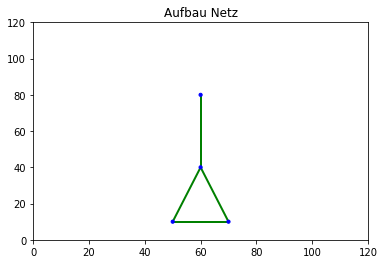

In [27]:
bmplot.plot(nw, title="Aufbau Netz")
plt.xlim([0,120])
plt.ylim([0,120])